## Relax Inc. Challenge - Predict User Adoption

Two tables - one with user info the other with user engagement. I think I'll need to aggregate the engagement data to flag users as having adopted the software. This needs to based on the logic of logging in on 3 seperate days in any 7-day period.

Then we can predict using the user data.

## 0.5 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

## 1.0 Load and Prep Data

### User Data

In [2]:
users = pd.read_csv('../data/takehome_users.csv', encoding='latin-1')

users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
#check info
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
#check for total duplicates
users[users.duplicated(keep=False)]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id


In [5]:
#check for duplicate users
users['object_id'].value_counts(0)

1        1
8004     1
7995     1
7996     1
7997     1
        ..
4003     1
4004     1
4005     1
4006     1
12000    1
Name: object_id, Length: 12000, dtype: int64

In [6]:
#make sure T/F columns only have 1s and 0s
print(users['opted_in_to_mailing_list'].value_counts())

print(users['enabled_for_marketing_drip'].value_counts())

0    9006
1    2994
Name: opted_in_to_mailing_list, dtype: int64
0    10208
1     1792
Name: enabled_for_marketing_drip, dtype: int64


In [7]:
#check creation source for consistency
users['creation_source'].value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

With those checks passing, I just want to update and explore my date fields a bit.

In [8]:
users['creation_time'] = pd.to_datetime(users['creation_time'])

In [9]:
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

In [10]:
users.dtypes

object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
dtype: object

In [11]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [12]:
#check min an max dates
print(users['creation_time'].min(), users['creation_time'].max())
print('--'*50)
print(users['last_session_creation_time'].min(), users['last_session_creation_time'].max())

2012-05-31 00:43:27 2014-05-30 23:59:19
----------------------------------------------------------------------------------------------------
2012-05-31 08:20:06 2014-06-06 14:58:50


### Engagement Data

In [13]:
engage = pd.read_csv('../data/takehome_user_engagement.csv')

engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [14]:
engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [15]:
#is the last column all 1s
engage['visited'].value_counts()

1    207917
Name: visited, dtype: int64

In [16]:
#convert timestamp to datetime
engage['time_stamp'] = pd.to_datetime(engage['time_stamp'])

engage.dtypes

time_stamp    datetime64[ns]
user_id                int64
visited                int64
dtype: object

## 2.0 Adding & Exploring Features

### Engagement Data
We'll snake draft it and start with engagement this time.

In [17]:
# Convert 'time_stamp' column to datetime type
def count_engagement(df):
    """Run through engagement data and count the number of visits in 7-day windows """
    count_df = df.copy()

    count_df['time_stamp'] = pd.to_datetime(count_df['time_stamp'])

    # Sort the DataFrame by 'time_stamp'
    count_df = count_df.sort_values('time_stamp')

    # Set 'time_stamp' column as the DataFrame index
    count_df = count_df.set_index('time_stamp')

    # Resample the DataFrame using a 7-day window and count the number of 'visited' per user
    count_per_user = count_df.groupby('user_id').apply(lambda x: x.resample('1D')['visited'].max().rolling(7, min_periods=1).sum()) #using max so we don't double count a single day. Want max 1, if anything. 

    output = count_per_user.reset_index().dropna() #dropping blank dates

    return output

In [18]:
#create new datframe with 7-day counts
engage_count = count_engagement(engage)

In [19]:
engage_count.head()

,user_id,time_stamp,visited
0,1,2014-04-22,1.0
1,2,2013-11-15,1.0
2,2,2013-11-16,1.0
3,2,2013-11-17,1.0
4,2,2013-11-18,1.0


In [20]:
#create final dataframe with max of 7-day logins
user_max = engage_count.groupby('user_id')['visited'].max().reset_index().rename(columns={'visited': 'max_7D_logins'})

user_max.head()

,user_id,max_7D_logins
0,1,1.0
1,2,3.0
2,3,1.0
3,4,1.0
4,5,1.0


In [21]:
#validate we shouldn't see more than 7
user_max['max_7D_logins'].max()

7.0

In [22]:
#nice! Let's create a flag for our target features
user_max['is_engaged'] = np.where(user_max['max_7D_logins'] >= 3.0, 1, 0)

user_max.drop('max_7D_logins', axis=1, inplace=True)

user_max.head()

,user_id,is_engaged
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


### User Data

I need to join in our 'is_engaged' target feature, but first I think we could do some feature engineering. My mind goes to counting total logins, but I think that is duplicative of our target feature, so that would kind of be like predicted our target variable with our target variable.

A few other possibilies do come to mind I want to try: 1. account_age 2. has_invited_user 3. Time between creation and 2nd login

In [23]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


#### Add account Age

In [24]:
users.last_session_creation_time.max()

Timestamp('2014-06-06 14:58:50')

In [25]:
#based on the last access being 6/6/14 I'll asume the data was run then.
report_date = datetime.strptime('6/6/14', '%m/%d/%y')

users['account_age_days'] = (report_date - users['creation_time']).dt.days

#### Create Referall Table

In [26]:
#create an array of each unique user that has made a referral
referrals = users['invited_by_user_id'].dropna().unique()

In [27]:
#create dataframe
user_ref = pd.DataFrame({'ref_user_id': referrals}).astype(int)

#add a flag
user_ref['has_made_ref'] = 1

In [28]:
user_ref.head()

,ref_user_id,has_made_ref
0,10803,1
1,316,1
2,1525,1
3,5151,1
4,5240,1


#### Time Between 1st and 2nd Login
We'll need the original engagement table for this

In [29]:
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [30]:
#group by user - using the head method to only keep the first two records
sec_login = engage.sort_values(by=['user_id','time_stamp']).groupby('user_id').head(2)

#calculate the time difference
sec_login['second_login_time_diff'] = sec_login.groupby('user_id')['time_stamp'].diff()

#convert timebetween to hours
sec_login['second_login_time_diff'] = sec_login['second_login_time_diff'] / pd.Timedelta(days=1)

#drop nas to get only 2nd logins 
sec_login.dropna(inplace=True)

#drop excess data fields
sec_login.drop(['time_stamp','visited'], axis=1, inplace=True)

sec_login.reset_index(drop=True, inplace=True)

In [31]:
sec_login.head(10)

,user_id,second_login_time_diff
0,2,14.0
1,10,6.0
2,19,5.0
3,20,1.0
4,25,1.0
5,33,6.0
6,42,33.0
7,43,30.0
8,50,18.0
9,53,2.0


### Join in New Features

#### Has Made Referral

In [32]:
users_new = pd.merge(users, user_ref, left_on='object_id', right_on='ref_user_id', how='left').drop('ref_user_id', axis=1)

users_new.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,account_age_days,has_made_ref
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,44,NaN
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,202,NaN
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,443,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,380,NaN
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,504,NaN


### Second Login Time

In [33]:
users_new = pd.merge(users_new, sec_login, left_on='object_id', right_on='user_id', how='left').drop('user_id', axis=1)

users_new.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,account_age_days,has_made_ref,second_login_time_diff
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,44,NaN,NaN
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,202,NaN,14.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,443,1.0,NaN
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,380,NaN,NaN
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,504,NaN,NaN


### Targt Feature - is_engaged

In [34]:
user_eng = pd.merge(users_new, user_max, left_on='object_id', right_on='user_id', how='left').drop('user_id', axis=1)

In [35]:
user_eng.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,account_age_days,has_made_ref,second_login_time_diff,is_engaged
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,44,NaN,NaN,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,202,NaN,14.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,443,1.0,NaN,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,380,NaN,NaN,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,504,NaN,NaN,0.0


## Final Explorations & Pre-Processing

With some features added, let's do some final cleanup and the build a pre-processing pipeline.

i want to drop our creation_time, last_session, name, and email and user_id. Creation time is accounted for in the age, name and email shouldn't be relevant.last session time doesn't feel relevant with our target feature being ANY 7-day window. I'll then change my referred by user_id to an object and make sure all my flags are integers.

In [36]:
user_eng.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  account_age_days            12000 non-null  int64         
 11  has_made_ref                2564 non-null   float64   

In [37]:
#drop columns
user_eng.drop(columns=['object_id','creation_time','name','email','last_session_creation_time'], inplace=True)

In [38]:
#fill NAs and convert to objects for flags and ids
user_eng['invited_by_user_id'] = user_eng['invited_by_user_id'].fillna(0).astype(object)
user_eng['has_made_ref'] = user_eng['has_made_ref'].fillna(0).astype(object)
user_eng['is_engaged'] = user_eng['is_engaged'].fillna(0).astype(object)
user_eng['org_id'] = user_eng['org_id'].fillna(0).astype(object)
user_eng['opted_in_to_mailing_list'] = user_eng['opted_in_to_mailing_list'].fillna(0).astype(object)
user_eng['enabled_for_marketing_drip'] = user_eng['enabled_for_marketing_drip'].fillna(0).astype(object)


In [47]:
user_eng.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,account_age_days,has_made_ref,second_login_time_diff,is_engaged
0,GUEST_INVITE,1,0,11,10803.0,44,0.0,NaN,0.0
1,ORG_INVITE,0,0,1,316.0,202,0.0,14.0,1.0
2,ORG_INVITE,0,0,94,1525.0,443,1.0,NaN,0.0
3,GUEST_INVITE,0,0,1,5151.0,380,0.0,NaN,0.0
4,GUEST_INVITE,0,0,193,5240.0,504,0.0,NaN,0.0


In [39]:
user_eng.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_source             12000 non-null  object 
 1   opted_in_to_mailing_list    12000 non-null  object 
 2   enabled_for_marketing_drip  12000 non-null  object 
 3   org_id                      12000 non-null  object 
 4   invited_by_user_id          12000 non-null  object 
 5   account_age_days            12000 non-null  int64  
 6   has_made_ref                12000 non-null  object 
 7   second_login_time_diff      2588 non-null   float64
 8   is_engaged                  12000 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 937.5+ KB


### Visualize

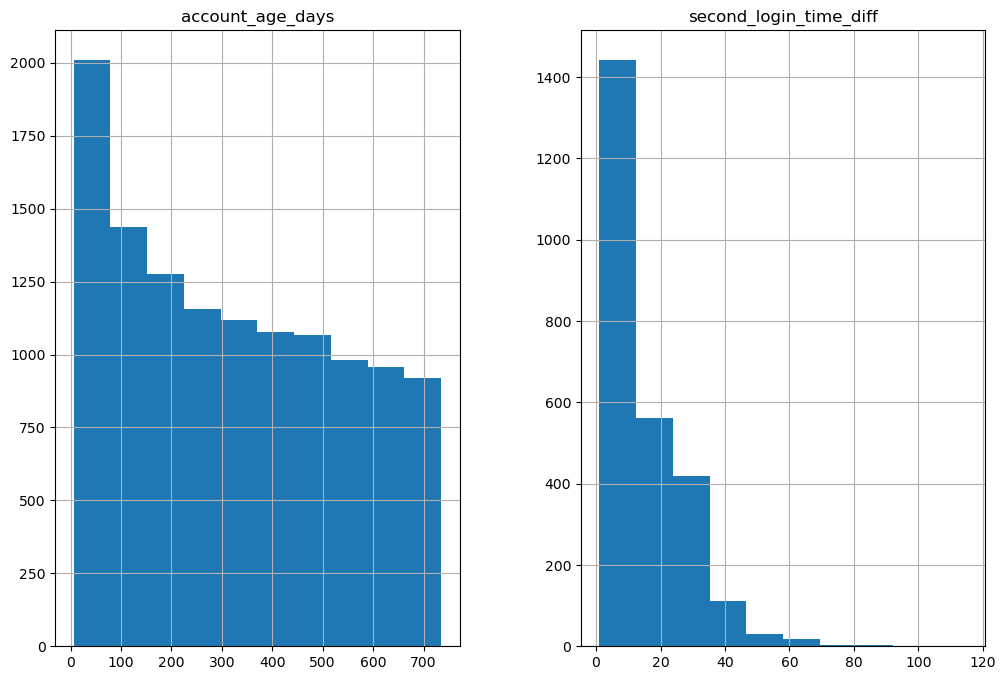

In [40]:
user_eng.hist(figsize=(12,8))

plt.show()

It Looks like the second_login might have some outliers. Let's see the details

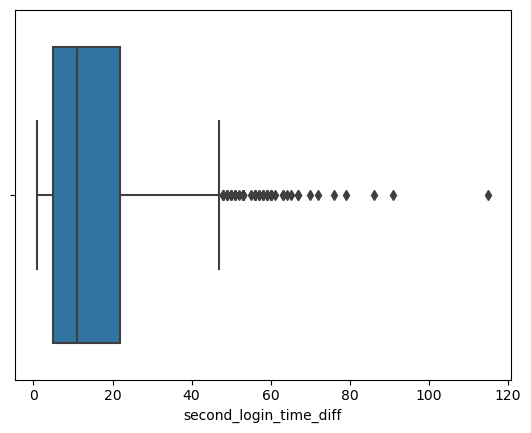

In [48]:
#view boxplot, but ignore 0 and these are only users that never logged in again
sns.boxplot(data=user_eng, x='second_login_time_diff')

plt.show()

On average our users are login for a second time within 10-15 days. Our outliers in the boxplot are outside of around 42 or so. I will drop any records past 60 days. I believe most of our users will use and adopt or drop-off within that 2-month timeframe so I don't want to skew results too much.

In [51]:
#drop those >= 50

#create mask
mask = user_eng.second_login_time_diff>=50

#drop
user_eng = user_eng[~mask] #only values not in mas

user_eng.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,account_age_days,has_made_ref,second_login_time_diff,is_engaged
0,GUEST_INVITE,1,0,11,10803.0,44,0.0,NaN,0.0
1,ORG_INVITE,0,0,1,316.0,202,0.0,14.0,1.0
2,ORG_INVITE,0,0,94,1525.0,443,1.0,NaN,0.0
3,GUEST_INVITE,0,0,1,5151.0,380,0.0,NaN,0.0
4,GUEST_INVITE,0,0,193,5240.0,504,0.0,NaN,0.0


### Pre-Processing Pipeline